In [237]:
import json
import pathlib

import matplotlib.ticker
import matplotlib.pylab as plt
import pandas as pd

from hubbardml import keys
from hubbardml import plots

import olivines

In [238]:
# EXPERIMENT_DIR = pathlib.Path(
#     "outputs/train.batch_size=32,train.max_epochs=4000/2023-07-27_14-28-01"
# )
# EXPERIMENT_DIR = pathlib.Path(
#     "outputs/train.batch_size=16,train.max_epochs=10000/2023-07-28_15-29-57"
# )
# EXPERIMENT_DIR = pathlib.Path(
#     "outputs/train.batch_size=1024,train.max_epochs=10000/2023-08-08_09-55-09"
# )
EXPERIMENT_DIR = pathlib.Path(
    "outputs/olivines/train.batch_size=1024,train.max_epochs=20000/2023-08-10_10-33-42"
)
EXPERIMENT_DIR = pathlib.Path(
    "outputs/olivines/train.batch_size=32,train.max_epochs=20000/2023-08-10_22-53-27"
)
EXPERIMENT_DIR = pathlib.Path(
    "outputs/olivines/batch_size=64,max_epochs=12000/2023-08-20_21-47-51"
)
EXPERIMENT_DIR = pathlib.Path(
    "outputs/olivines/batch_size=32,max_epochs=12000/2023-08-21_10-38-09"
)
DATASET = "dataset.json"
RESULTS_FILE = "hubbard_u_olivines.json"

In [239]:
uv_data = pd.read_json(EXPERIMENT_DIR / DATASET)
labels = {
    'LiFePO4': 'Li$_{x}$FePO$_4$',
    'LiMnPO4': 'Li$_{x}$MnPO$_4$',
    "LiFe0.5Mn0.5PO4": "Li$_{x}$Fe$_{0.5}$Mn$_{0.5}$PO$_4$",
}
uv_data

,dir,material,is_vdw,uv_iter,formula,cell,n_atoms_uc,person,structure_index,pw_time_unix,...,atom_2_occs_2,atom_2_frac_coords,atom_2_starting_mag,atom_2_final_mag,param_delta,species,label,colour,sc_paths,occupation
91340,/Users/azadoks/Data/uv_ml/iurii/Olivines/LiFe0...,A1_Li0.00Mn0.5Fe0.5PO4,False,1,,"[18.5936265225, -0.0009754750000000001, 0.0072...",24,iurii,68,1618231488,...,"[[0.997, 0.0, 0.0, 0.0, 0.0], [0.0, 0.992, 0.0...","[-0.0073431, -0.00041139999999999997, -0.01556...",0.0,-3.9118,-0.1663,[Fe],Fe,#E06633,/Users/azadoks/Data/uv_ml/iurii/Olivines/LiFe0...,0.0
91442,/Users/azadoks/Data/uv_ml/iurii/Olivines/LiFe0...,A1_Li0.00Mn0.5Fe0.5PO4,False,1,,"[18.5936265225, -0.0009754750000000001, 0.0072...",24,iurii,68,1618231488,...,"[[0.092, 0.014, 0.0, -0.006, 0.0], [0.014, 0.1...","[-0.056849399999999994, 0.4995747, -0.51556099...",0.0,3.9077,-0.0563,[Fe],Fe,#E06633,/Users/azadoks/Data/uv_ml/iurii/Olivines/LiFe0...,0.0
91562,/Users/azadoks/Data/uv_ml/iurii/Olivines/LiFe0...,A1_Li0.00Mn0.5Fe0.5PO4,False,1,,"[18.5936265225, -0.0009754750000000001, 0.0072...",24,iurii,68,1618231488,...,"[[0.991, -0.033, 0.0, -0.039, 0.0], [-0.033, 0...","[0.5048417, -0.0004909, -0.39822029999999997]",0.0,-3.4365,0.9313,[Mn],Mn,#9C7AC7,/Users/azadoks/Data/uv_ml/iurii/Olivines/LiFe0...,0.0
91682,/Users/azadoks/Data/uv_ml/iurii/Olivines/LiFe0...,A1_Li0.00Mn0.5Fe0.5PO4,False,1,,"[18.5936265225, -0.0009754750000000001, 0.0072...",24,iurii,68,1618231488,...,"[[0.048, -0.008, 0.0, 0.016, 0.0], [-0.008, 0....","[0.43096, 0.4996846, -0.8981882999999999]",0.0,3.4364,0.9315,[Mn],Mn,#9C7AC7,/Users/azadoks/Data/uv_ml/iurii/Olivines/LiFe0...,0.0
93558,/Users/azadoks/Data/uv_ml/iurii/Olivines/LiFe0...,A1_Li0.00Mn0.5Fe0.5PO4,False,2,,"[18.577492166, -0.0007413610000000001, 0.00680...",24,iurii,69,1618391955,...,"[[0.997, 0.0, 0.0, 0.0, 0.0], [0.0, 0.991, 0.0...","[-0.0069193, -0.00040439999999999996, -0.01602...",0.0,-3.8419,0.1001,[Fe],Fe,#E06633,/Users/azadoks/Data/uv_ml/iurii/Olivines/LiFe0...,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228640,/Users/azadoks/Data/uv_ml/iurii/Olivines/LiMnP...,B5_Li1.00MnPO4,False,3,,"[19.7940850765, 0.0, 0.0, 0.0, 11.511736551, 0...",28,iurii,130,1594749234,...,"[[0.996, -0.001, 0.0, -0.001, 0.0], [-0.001, 0...","[0.4372178, 0.5, -0.9466146]",0.0,-4.2040,0.1188,[Mn],Mn,#9C7AC7,/Users/azadoks/Data/uv_ml/iurii/Olivines/LiMnP...,1.0
230526,/Users/azadoks/Data/uv_ml/iurii/Olivines/LiMnP...,B5_Li1.00MnPO4,False,4,,"[19.7940850765, 0.0, 0.0, 0.0, 11.511736551, 0...",28,iurii,131,1595848609,...,"[[0.02, 0.002, 0.0, 0.006, 0.0], [0.002, 0.057...","[-0.001527, 0.0, 0.0021371999999999997]",0.0,4.2058,-0.0129,[Mn],Mn,#9C7AC7,/Users/azadoks/Data/uv_ml/iurii/Olivines/LiMnP...,1.0
230628,/Users/azadoks/Data/uv_ml/iurii/Olivines/LiMnP...,B5_Li1.00MnPO4,False,4,,"[19.7940850765, 0.0, 0.0, 0.0, 11.511736551, 0...",28,iurii,131,1595848609,...,"[[0.02, -0.002, 0.0, 0.006, 0.0], [-0.002, 0.0...","[0.4984724, 0.0, -0.4466148]",0.0,4.2058,-0.0129,[Mn],Mn,#9C7AC7,/Users/azadoks/Data/uv_ml/iurii/Olivines/LiMnP...,1.0
230748,/Users/azadoks/Data/uv_ml/iurii/Olivines/LiMnP...,B5_Li1.00MnPO4,False,4,,"[19.7940850765, 0.0, 0.0, 0.0, 11.511736551, 0...",28,iurii,131,1595848609,...,"[[0.996, 0.001, 0.0, -0.001, 0.0], [0.001, 0.9...","[-0.06278249999999999, 0.5, -0.4978627]",0.0,-4.2058,-0.0129,[Mn],Mn,#9C7AC7,/Users/azadoks/Data/uv_ml/iurii/Olivines/LiMnP...,1.0


In [240]:
uv_data[uv_data[keys.PARAM_TYPE] == keys.PARAM_V].groupby(keys.MATERIAL).value_counts([olivines.Keys.OCCUPATION])

Series([], Name: count, dtype: int64)

In [241]:
sum(uv_data[keys.PARAM_OUT] < 0.25)

0

In [242]:
def create_plots(df: pd.DataFrame, logy=False, scale=1.0):
    comparison_plots = {}

    if olivines.Keys.TRAIN_RMSE in df:
        cols = [olivines.Keys.TRAIN_RMSE, olivines.Keys.MODEL_RMSE]
        series_labels = 'ML (train)', 'ML (validate)'
    else:
        cols = [olivines.Keys.MODEL_RMSE]
        series_labels = ('ML (validate)',)

    for material in df[olivines.Keys.MATERIAL].unique():
        frame = df[df[olivines.Keys.MATERIAL] == material]
        ref_rmse = frame.iloc[0][olivines.Keys.REF_RMSE]  # They are all the same

        grouped = frame.groupby(olivines.Keys.NUM_OCCUPATIONS)[cols]
        mins = grouped.min()
        maxs = grouped.max()
        means = grouped.mean()

        errors = [[means[c] - mins[c], maxs[c] - means[c]] for c in cols]

        fig = plt.figure(figsize=(6 * scale, 4 * scale))
        ax = fig.gca()

        ax = means.plot(
            ax=ax,
            # colormap=plots.colourmap,
            color=plots.train_validate_colours.values(),
            yerr=errors,
            fmt='o--',
            logy=logy,
            solid_capstyle='projecting',
            capsize=5,
            capthick=2,
            title=labels[material],
            # linewidth=3,
            # alpha=0.5,
            ylabel='RMSE (eV)',
            xlabel='Num. training occupations',
        );

        # Plot the baseline RMSE
        ax.plot(
            [df[olivines.Keys.NUM_OCCUPATIONS].min(),
             df[olivines.Keys.NUM_OCCUPATIONS].max()],
            [ref_rmse, ref_rmse],
            c=plots.train_validate_colours[keys.REFERENCE]
        )

        ax.legend((f"Ref {ref_rmse * 1000:.0f} meV",) + series_labels)
        ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
        ax.set_ylim([0, 0.6])

        comparison_plots[material] = ax

    return comparison_plots

# Olivines analysis

In [243]:
results_file = EXPERIMENT_DIR / RESULTS_FILE
with open(results_file, 'r') as file:
    hubbard_u_olivines = pd.DataFrame(json.load(file))
hubbard_u_olivines;

In [244]:
save_to = EXPERIMENT_DIR / "plots"
save_to.mkdir(exist_ok=True)
save_to

PosixPath('outputs/olivines/batch_size=32,max_epochs=12000/2023-08-21_10-38-09/plots')

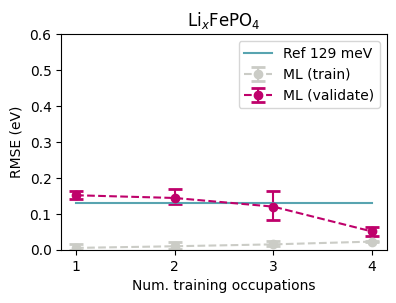

In [245]:
for material, ax in create_plots(hubbard_u_olivines, scale=0.7).items():
    ax.get_figure().savefig(save_to / f"{material}_U_occs_comparison.pdf", bbox_inches='tight')

In [246]:
results_file = 'hubbard_v_olivines.json'
with open(results_file, 'r') as file:
    hubbard_v_olivines = pd.DataFrame(json.load(file))

for material, ax in create_plots(hubbard_v_olivines, logy=True, scale=0.7).items():
    ax.get_figure().savefig(save_to / "f{material}_V_occs_comparison.pdf", bbox_inches='tight')
    
save_to

FileNotFoundError: [Errno 2] No such file or directory: 'hubbard_v_olivines.json'

In [ ]:
uv_data